In [16]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import medmnist
from PIL import Image
from medmnist import INFO, Evaluator
from tensorflow.keras.utils import plot_model
from clearml import Task, OutputModel, Logger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import seaborn as sns


## Dataset Preparation and Visualization

{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1', 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b', 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1', 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c', 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist_224.npz

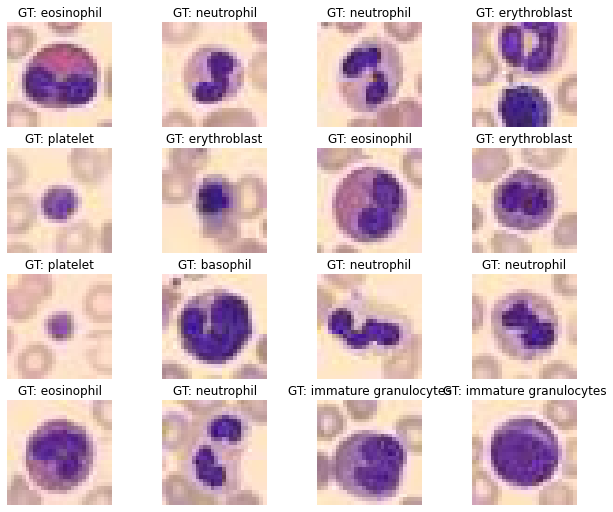

In [17]:
# BloodMNIST dataset information
data_flag = 'bloodmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
classes = info['label']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

cml_labels = {classes[str(i)]: i for i in range(n_classes)}
print(info)

# Normalize data and class convertiong into one-hot encoded label
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values ranging from 0 to 255 to 0 and 1
    image = (image - 0.5) / 0.5  # Normalize to [-1, 1] and centered around 0
    label = tf.one_hot(label, n_classes) #One-hot encoding transforms the integer class label into a binary vector of length n_classes
    return image, label

#load data
train_dataset = DataClass(split='train', transform=None, download=True)
val_dataset = DataClass(split='val', transform=None, download=True)
test_dataset = DataClass(split='test', transform=None, download=True)

print(f'Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

# count the number of samples in each class
count = []
for i in range(n_classes):
    count.append((train_dataset.labels == i).sum())
    print(f'{classes[str(i)]}: {count[i]}')

def dataset_to_tf(data, batch_size):
    images = []
    labels = []
    for img, lbl in data:
        images.append(np.array(img))
        labels.append(lbl[0])  # Convert to a scalar
    images = np.stack(images)
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(preprocess)
    return dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    
batch_size = 2048
sample_size = 16

train_loader = dataset_to_tf(train_dataset, batch_size)
val_loader = dataset_to_tf(val_dataset, batch_size)
test_loader = dataset_to_tf(test_dataset, batch_size)

# Show some random training images
images, labels = next(iter(train_loader))
plt.figure()
for i in range(sample_size):
    fig = plt.subplot(4, 4, i + 1)
    plt.imshow((images[i].numpy() * 0.5 + 0.5).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'GT: {classes[str(tf.argmax(labels[i]).numpy())][:21]}')
    
plt.subplots_adjust(right=1.5, top=1.8)
plt.show()


# The DNN

In [19]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from clearml import Task, OutputModel, Logger

def build_dnn_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    model.add(Dense(1024, activation='relu'))  # First fully connected layer
    model.add(Dense(128, activation='relu'))   # Second fully connected layer
    model.add(Dropout(0.25))  # Dropout layer for regularization
    model.add(Dense(8, activation='softmax'))  # Output layer with softmax activation

    return model

input_shape = (28, 28, 3)
dnn_model = build_dnn_model(input_shape)

dnn_model.summary()

# Plot and save the model architecture
plot_model(dnn_model, to_file='dnn_model.png', show_shapes=True)

# Set environment for ClearML
os.environ['CLEARML_WEB_HOST'] = 'https://app.clear.ml'
os.environ['CLEARML_API_HOST'] = 'https://api.clear.ml'
os.environ['CLEARML_FILES_HOST'] = 'https://files.clear.ml'
os.environ['CLEARML_API_ACCESS_KEY'] = 'UM467TGFU1L1ICCP9LHV'
os.environ['CLEARML_API_SECRET_KEY'] = 'eBhwfcZCImDq6FZSTDByWrfCAMLsKA5D0ZzUfUuW9i2uYFMkPJ'

# Initialize ClearML task
train_number = 1 
task = Task.init(project_name="BloodMNIST-Group6", task_name=f"DNN training {train_number}")
learning_rate = 0.001
dnn_model.compile(optimizer=Adam(learning_rate), 
                  loss=CategoricalCrossentropy(), 
                  metrics=['accuracy'])

# Update hyperparameters to ClearML
params = {
    "number_of_epochs": 50,
    "batch_size": batch_size,
    "base_lr": learning_rate,
    "decrease_lr": "by 10 every 30 epochs",
    "loss_func": "CategoricalCrossentropy",
    "optimizer": "Adam"
}
params = task.connect(params)

# Upload model to ClearML
output_model = OutputModel(task=task)
output_model.update_labels(cml_labels)
output_model.update_design(config_dict=dnn_model.get_config())

# ClearML Callback for reporting metrics
class ClearMLCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        Logger.current_logger().report_scalar("Loss", "training loss", iteration=epoch, value=logs["loss"])
        Logger.current_logger().report_scalar("Accuracy", "training accuracy", iteration=epoch, value=logs["accuracy"])
        Logger.current_logger().report_scalar("Loss", "val loss", iteration=epoch, value=logs["val_loss"])
        Logger.current_logger().report_scalar("Accuracy", "val accuracy", iteration=epoch, value=logs["val_accuracy"])

checkpoint = ModelCheckpoint(filepath='model_{epoch}.h5', save_best_only=True, monitor='val_loss', mode='min')

# Training the model
history = dnn_model.fit(train_loader, 
                        epochs=50, 
                        validation_data=val_loader, 
                        callbacks=[ClearMLCallback(), checkpoint])

# Evaluate the model
test_loss, test_accuracy = dnn_model.evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Close ClearML task
task.close()

print('Finished Training')
dnn_model.save('CNN_model.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2352)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              2409472   
                                                                 
 dense_11 (Dense)            (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 2541704 (9.70 MB)
Trainable params: 2541704 (9.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
5/6 [

/home/jix033/.local/lib/python3.9/site-packages/clearml/binding/frameworks/tensorflow_bind.py:1918: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



6/6 [==============================] - 6s 775ms/step - loss: 2.4438 - accuracy: 0.2797 - val_loss: 1.5403 - val_accuracy: 0.3522
Epoch 2/50
6/6 [==============================] - 4s 701ms/step - loss: 1.4736 - accuracy: 0.4347 - val_loss: 1.1437 - val_accuracy: 0.6297
Epoch 3/50
6/6 [==============================] - 4s 718ms/step - loss: 1.1667 - accuracy: 0.5791 - val_loss: 0.9648 - val_accuracy: 0.6822
Epoch 4/50
6/6 [==============================] - 4s 696ms/step - loss: 1.0449 - accuracy: 0.6368 - val_loss: 0.8508 - val_accuracy: 0.7179
Epoch 5/50
6/6 [==============================] - 4s 710ms/step - loss: 0.9442 - accuracy: 0.6679 - val_loss: 0.7743 - val_accuracy: 0.7325
Epoch 6/50
6/6 [==============================] - 4s 710ms/step - loss: 0.8785 - accuracy: 0.6883 - val_loss: 0.7232 - val_accuracy: 0.7395
Epoch 7/50
6/6 [==============================] - 4s 733ms/step - loss: 0.8296 - accuracy: 0.7052 - val_loss: 0.6962 - val_accuracy: 0.7599
Epoch 8/50
6/6 [===============

/home/jix033/.local/lib/python3.9/site-packages/clearml/binding/frameworks/tensorflow_bind.py:1918: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



6/6 [==============================] - 4s 714ms/step - loss: 0.5674 - accuracy: 0.8050 - val_loss: 0.5091 - val_accuracy: 0.8300
Epoch 17/50
6/6 [==============================] - 4s 711ms/step - loss: 0.5546 - accuracy: 0.8084 - val_loss: 0.4986 - val_accuracy: 0.8335
Epoch 18/50
6/6 [==============================] - 4s 717ms/step - loss: 0.5358 - accuracy: 0.8175 - val_loss: 0.4892 - val_accuracy: 0.8312
Epoch 19/50
6/6 [==============================] - 4s 708ms/step - loss: 0.5221 - accuracy: 0.8205 - val_loss: 0.4761 - val_accuracy: 0.8306
Epoch 20/50
6/6 [==============================] - 4s 709ms/step - loss: 0.5104 - accuracy: 0.8238 - val_loss: 0.4616 - val_accuracy: 0.8429
Epoch 21/50
6/6 [==============================] - 4s 710ms/step - loss: 0.4944 - accuracy: 0.8277 - val_loss: 0.4581 - val_accuracy: 0.8388
Epoch 22/50
6/6 [==============================] - 4s 722ms/step - loss: 0.4790 - accuracy: 0.8316 - val_loss: 0.4566 - val_accuracy: 0.8470
Epoch 23/50
6/6 [========

## Plotting the Learning Curves for DNN Model

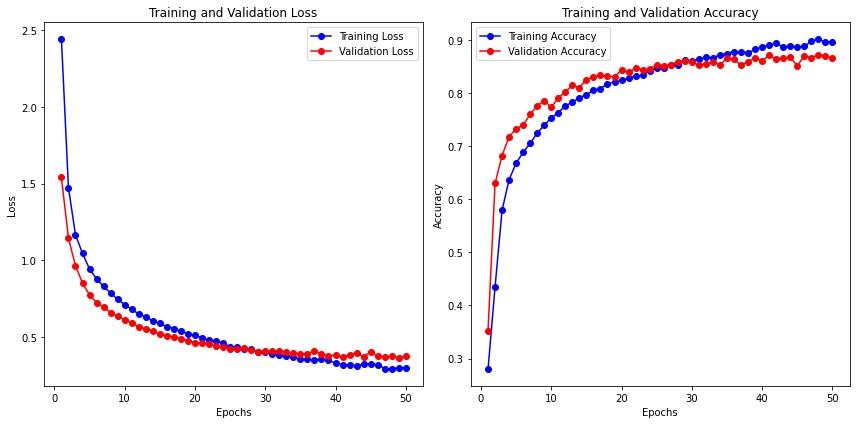

In [20]:
import matplotlib.pyplot as plt

# Access the history from the training session
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Create subplot for loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Create subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Plotting the ROC curve for DNN model

107/107 [==============================] - 0s 2ms/step


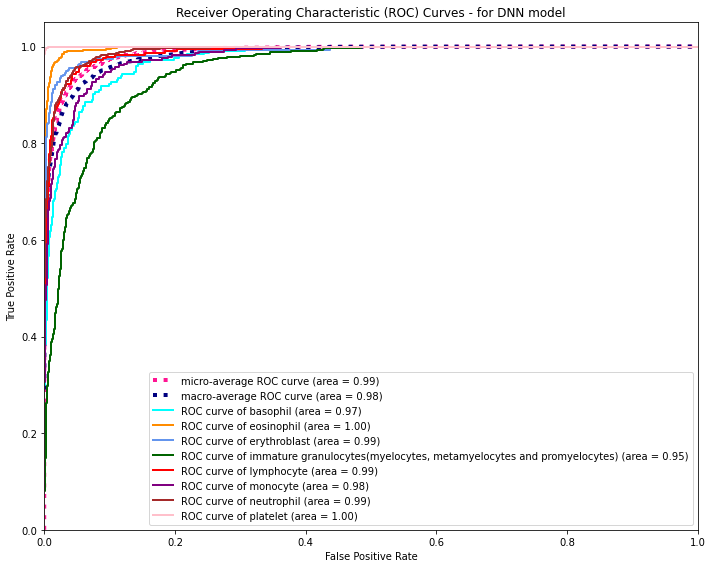

In [51]:
# Make predictions
y_pred_prob = dnn_model.predict(X_test)

# Binarize the labels in a one-vs-all fashion for ROC computation
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
cell_types = [info['label'][str(i)] for i in range(n_classes)]
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink']

# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, (cell_type, color) in enumerate(zip(cell_types, colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
                   ''.format(cell_type, roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves - for DNN model')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curves.pdf")
plt.show()

## Plotting the F1 Scores for DNN Model

2/2 [==============================] - 0s 11ms/step


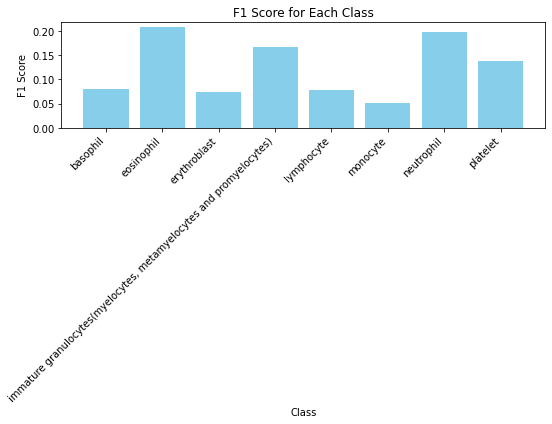

In [55]:
from sklearn.metrics import f1_score

# Make predictions on the test set
y_pred = dnn_model.predict(test_loader)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels to binary format
y_true_labels = np.argmax(y_test, axis=1)

# Calculate F1 score for each class
f1_scores = f1_score(y_true_labels, y_pred_labels, average=None)

cell_types = [info['label'][str(i)] for i in range(n_classes)]

# Plot F1 scores for each class
plt.figure(figsize=(8, 6))
plt.bar(range(n_classes), f1_scores, color='skyblue')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.xticks(range(n_classes), cell_types, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# CNN


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from medmnist import INFO, Evaluator
from medmnist.info import INFO
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, LeakyReLU, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


data_flag = 'bloodmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
classes = info['label']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

# Load data
train_dataset = DataClass(split='train', download=True)
val_dataset = DataClass(split='val', download=True)
test_dataset = DataClass(split='test', download=True)

# Example of how to extract X_train and y_train from the dataset
X_train = np.stack([np.array(data[0]) for data in train_dataset])
y_train = np.array([data[1] for data in train_dataset])

# Normalize and preprocess data
X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
X_train = (X_train - 0.5) / 0.5  # Further scale to [-1, 1]

# Convert y_train to one-hot encoded labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

# You can now use X_train and y_train in your model training
######################################try the data
# Extract X_test and y_test from the dataset
X_test = np.stack([np.array(data[0]) for data in test_dataset])
y_test = np.array([data[1] for data in test_dataset])

# Normalize and preprocess X_test
X_test = X_test.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
X_test = (X_test - 0.5) / 0.5  # Further scale to [-1, 1]

# Convert y_test to one-hot encoded labels
y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

######################################end



from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Define the input and convolutional layers of the model
inputs = Input(shape=(28, 28, n_channels))
conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
pool1 = MaxPooling2D((2, 2))(conv1)
drop1 = Dropout(0.25)(pool1)  # Add dropout layer

conv2 = Conv2D(64, (3, 3), activation='relu')(drop1)
pool2 = MaxPooling2D((2, 2))(conv2)
drop2 = Dropout(0.25)(pool2)  # Add dropout layer

flattened = Flatten()(drop2)
hidden = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(flattened)  # Add L2 regularization
drop3 = Dropout(0.5)(hidden)  # Add dropout layer

outputs = Dense(n_classes, activation='softmax')(drop3)  # Using softmax for multi-class classification

# Create the model
cnn_model = Model(inputs=inputs, outputs=outputs)

# Compile the model with SGD optimizer and categorical cross-entropy loss
cnn_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1)


Using downloaded and verified file: /home/jix033/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/jix033/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/jix033/.medmnist/bloodmnist.npz
Shape of X_train: (11959, 28, 28, 3)
Shape of y_train: (11959, 8)
Shape of X_test: (3421, 28, 28, 3)
Shape of y_test: (3421, 8)
Epoch 1/50


2024-06-03 00:53:11.540967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


85/85 [==============================] - 2s 12ms/step - loss: 1.8176 - accuracy: 0.3962 - val_loss: 1.3223 - val_accuracy: 0.6380
Epoch 2/50
85/85 [==============================] - 1s 9ms/step - loss: 1.2968 - accuracy: 0.6034 - val_loss: 0.9904 - val_accuracy: 0.7400
Epoch 3/50
85/85 [==============================] - 1s 9ms/step - loss: 1.0509 - accuracy: 0.6942 - val_loss: 0.9015 - val_accuracy: 0.7483
Epoch 4/50
85/85 [==============================] - 1s 8ms/step - loss: 0.9013 - accuracy: 0.7476 - val_loss: 0.7539 - val_accuracy: 0.8077
Epoch 5/50
85/85 [==============================] - 1s 8ms/step - loss: 0.8471 - accuracy: 0.7662 - val_loss: 0.6866 - val_accuracy: 0.8370
Epoch 6/50
85/85 [==============================] - 1s 9ms/step - loss: 0.7896 - accuracy: 0.7848 - val_loss: 0.6432 - val_accuracy: 0.8344
Epoch 7/50
85/85 [==============================] - 1s 8ms/step - loss: 0.7348 - accuracy: 0.8087 - val_loss: 0.6231 - val_accuracy: 0.8562
Epoch 8/50
85/85 [============

In [39]:
# Predict probabilities for the test set
preds_nn = cnn_model.predict(X_test)

# Binarize the labels in a one-vs-all fashion for ROC computation
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], preds_nn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


107/107 [==============================] - 0s 2ms/step


## Plotting the Learning Curves for CNN Model

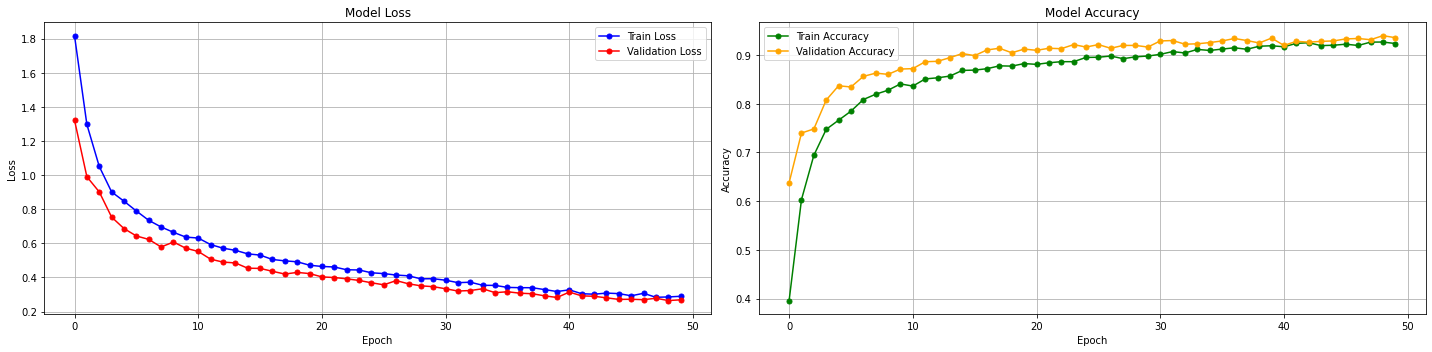

In [40]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))  # 1 row, 2 columns

# First subplot for loss
axs[0].plot(history.history['loss'], marker='o', linestyle='-', color='blue', markersize=5, label='Train Loss')
axs[0].plot(history.history['val_loss'], marker='o', linestyle='-', color='red', markersize=5, label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Second subplot for accuracy
axs[1].plot(history.history['accuracy'], marker='o', linestyle='-', color='green', markersize=5, label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange', markersize=5, label='Validation Accuracy')
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save the entire figure as a PDF file
plt.savefig("training_results.pdf")

# Show the plot
plt.show()


## Plotting the ROC Curve for CNN Model

107/107 [==============================] - 0s 2ms/step


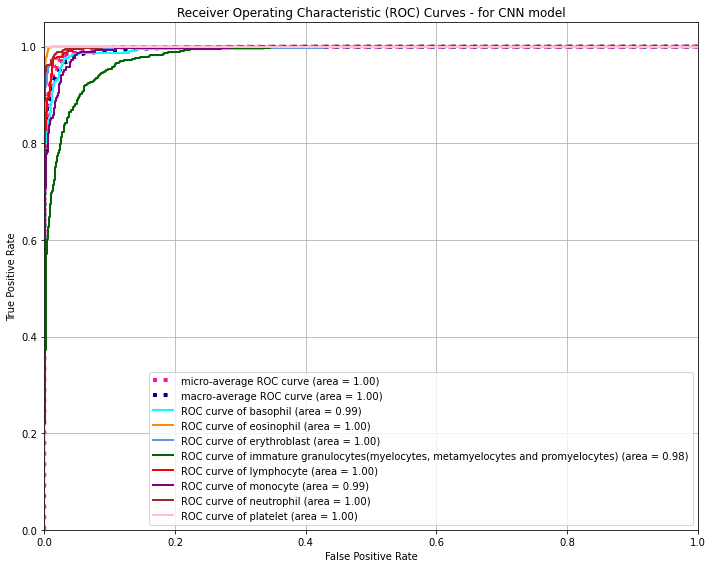

In [49]:
# Make predictions
y_pred_prob = cnn_model.predict(X_test)

# Binarize the labels in a one-vs-all fashion for ROC computation
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Retrieve cell type names
cell_types = [info['label'][str(i)] for i in range(n_classes)]
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink']
for i, (cell_type, color) in enumerate(zip(cell_types, colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
                   ''.format(cell_type, roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves - for CNN model')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves.pdf")
plt.show()

## Plotting the F1 Scores for CNN Model

107/107 [==============================] - 0s 2ms/step


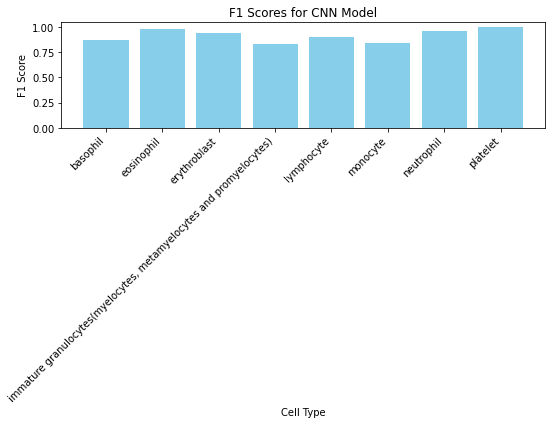

In [54]:
from sklearn.metrics import f1_score

# Make predictions on the test data
y_pred = cnn_model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test, axis=1)

# Compute F1 scores for each class
f1_scores = f1_score(y_true_class, y_pred_class, average=None)

# Plot F1 scores
plt.figure(figsize=(8, 6))
plt.bar(range(n_classes), f1_scores, color='skyblue')
plt.xticks(range(n_classes), cell_types, rotation=45, ha='right')
plt.xlabel('Cell Type')
plt.ylabel('F1 Score')
plt.title('F1 Scores for CNN Model')
plt.tight_layout()
plt.show()